In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir, streetview_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader, load_demo
from M1_util_train_test import load_model

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = 200
demo_dim = 7
demo_cols = [0,1,2,3,4,8,9]
image_size = str(64)
im_norm = '2'
model_run_date = "2211cvae-gan"
model_type = 'dcgan'
loss_func = 'mse'
model_class = 'gan'
base_lr = '0.0002'
weight_decay = '0'
sampling = 'clustered'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', str(latent_dim), 
                     '--image_size', image_size, \
                     '--im_norm', im_norm, '--model_run_date', model_run_date, '--model_type', model_type, \
                     '--loss_func', loss_func, '--model_class', model_class, \
                     '--base_lr', base_lr, '--weight_decay', weight_decay, \
                     '--demo_channels', str(demo_dim), \
                     '--sampling', sampling])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']


discriminator = load_model('dcgan', 'Discriminator', config)
config['model_config']['model_class'] = 'vae'
encoder = load_model('dcgan', 'Discriminator', config)
config['data_config']['demo_channels']  = 0
decoder = load_model('dcgan', 'Generator', config)

config['encoder'] = encoder
config['decoder'] = decoder
config['discriminator'] = discriminator

model = load_model('vae_gan', 'VAE_GAN', config)
model = model.to(device)
model.train();


In [12]:
encoder

Discriminator(
  (main): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 200, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [13]:
decoder

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [14]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 200, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (classification): Sequential(
    (0): Conv2d(2

In [4]:
# Satellite
train_loader, test_loader = image_loader(image_dir+args.zoomlevel+"/", data_dir, optim_config['batch_size'], 
         run_config['num_workers'], 
         data_config['image_size'], 
         data_version=args.data_version, 
         sampling=args.sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=args.im_norm,
         demo=True)

28280 images in dataset
3140 images in dataset


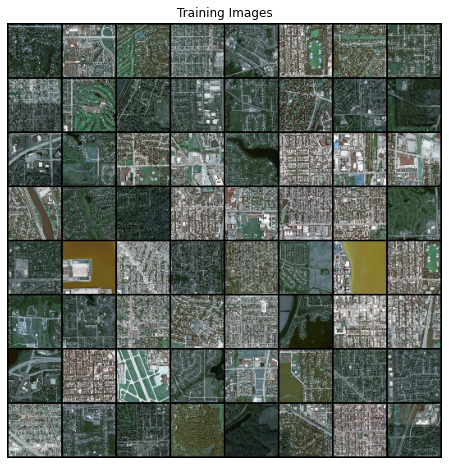

In [14]:
import torchvision.utils as vutils
temp = next(iter(train_loader))[1]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(temp, padding=2, normalize=True).cpu(),(1,2,0)));

In [6]:
# Streetview
model_run_date = '2209strt'
sampling = 'stratified'
data_version = '1571'

train_loader, test_loader = image_loader(streetview_dir, data_dir, 
                                         optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         data_version=data_version, 
                                         sampling=sampling, 
                                         recalculate_normalize=False,
                                         image_type='jpg',
                                         augment=False,
                                         norm=args.im_norm)

13311 images in dataset
1992 images in dataset


In [5]:
beta1 = 0.5
optimEnc = torch.optim.Adam(encoder.parameters(), lr=optim_config['base_lr'], betas=(beta1, 0.999))
optimDec = torch.optim.Adam(decoder.parameters(), lr=optim_config['base_lr'], betas=(beta1, 0.999))
optimDis = torch.optim.Adam(discriminator.parameters(), lr=optim_config['base_lr'] * 0.1)

In [6]:
num_batches = len(train_loader)
bce = nn.BCELoss()
mse = nn.MSELoss()

fixed_noise = torch.randn(64, latent_dim//2, 1, 1, device=device)
# noise_demo = torch.tensor([[-0.5, -0.5], [-0.5, 0], [-0.5, 0.5], [0,-0.5], [0,0], [0,0.5], [0.5,-0.5], [0.5,0]], device=device)
# noise_demo = noise_demo[:,:,None,None]

# row: same demo vector, different noise vectors
# column: same noise vector, different demo vectors
# noise = torch.cat([fixed_noise.repeat(8,1,1,1),noise_demo.repeat_interleave(8, dim=0)], axis=1)


In [7]:
gamma = 15
iters = 0


In [ ]:
start_epoch = 0

for epoch in range(start_epoch, start_epoch+optim_config['epochs']):
    
    loss_d = 0
    loss_g = 0

    for step, (image_list, data, demo) in enumerate(train_loader):
#     for data, _ in celeb_train_loader:
        
        demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)

        b_size = len(data)
        real_label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0., dtype=torch.float, device=device)
        
        ### Update Discriminator ###
        optimDis.zero_grad()
        
#         real = data.to(device)
        real = torch.cat((data.to(device), demo_conv),1)

        x_, mu, log_var = model.forward(real)
        x_ = torch.cat((x_, demo_conv), 1)

        noise = torch.randn(b_size, latent_dim//2, 1, 1).to(device)
        fake = model.decoder(noise)
        fake = torch.cat((fake, demo_conv), 1)

        output_real = model.discriminator(real)
        output_prior = model.discriminator(fake)
        output_dec = model.discriminator(x_)
        
        errD_real = bce(output_real, real_label)
        errD_prior = bce(output_prior, fake_label)
        errD_dec = bce(output_dec, fake_label)
        
        gan_loss = errD_real + errD_prior + errD_dec
        gan_loss.backward(retain_graph=True)
        
        optimDis.step()
        
        ### Update Decoder ### 
        optimDec.zero_grad()
        
        output_real = model.discriminator(real).view(-1,)
        output_prior = model.discriminator(fake).view(-1,)
        output_dec = model.discriminator(x_).view(-1,)
        
        errD_real = bce(output_real, real_label)
        errD_prior = bce(output_prior, fake_label)
        errD_dec = bce(output_dec, fake_label)
        
        gan_loss = errD_real + errD_prior + errD_dec
        
        discrim_feature = model.discriminator.return_latent(real)
        discrim_feature_ = model.discriminator.return_latent(x_)        
        
        rec_loss = mse(discrim_feature, discrim_feature_)
        
        dec_loss = gamma * rec_loss - gan_loss
        dec_loss.backward(retain_graph=True)
        
        optimDec.step()
        
        ### Update Encoder ###
        optimEnc.zero_grad()
        
        x_, mu, log_var = model.forward(real)
        x_ = torch.cat((x_, demo_conv), 1)

        discrim_feature = model.discriminator.return_latent(real)
        discrim_feature_ = model.discriminator.return_latent(x_)        
        rec_loss = mse(discrim_feature, discrim_feature_)
        

        prior_loss = 1 + log_var - mu.pow(2) - log_var.exp()
        prior_loss = torch.mean(-0.5 * torch.sum(prior_loss))
        
        enc_loss = prior_loss + 15 * rec_loss
        enc_loss.backward(retain_graph=True)
        
        optimEnc.step()
        
        iters += 1
        if iters % 50 == 0:
        # Output training stats
            print('[%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch, step, len(train_loader),
                     gan_loss.item(), prior_loss.item(),rec_loss.item(),
                     errD_real.item(),errD_dec.item(),errD_prior.item()))
            
    # Check how the generator is doing by saving G's output on fixed_noise
    if epoch % 10 == 0:

        with torch.no_grad():
            generated = model.decoder.forward(fixed_noise).detach().cpu()
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.axis("off")
        ax.set_title("Sampled Images")
        ax.imshow(np.transpose(torchvision.utils.make_grid(generated, padding=2, normalize=True).cpu(),(1,2,0)))
        fig.savefig(out_dir+"GAN_regen/VAEGAN_"+zoomlevel+"_"+str(model_config['latent_dim'])+"_"+
                model_run_date+"_"+str(epoch)+".png", bbox_inches='tight')
        
#     print(epoch, loss_d/num_batches, loss_g/num_batches)
    
        if config['run_config']['save']:
            torch.save({'epoch': epoch,
                'encoder_model_state_dict': encoder.state_dict(),
                'decoder_model_state_dict': decoder.state_dict(),
                'discriminator_model_state_dict': discriminator.state_dict(),
                'optimEnc': optimEnc.state_dict(),
                'optimDec': optimDec.state_dict(),
                'optimDis': optimDis.state_dict(),
                'config': config},
                model_dir+"VAEGAN_"+zoomlevel+"_"+str(model_config['latent_dim'])+"_"+
                model_run_date+"_"+str(epoch)+".pt")

[0][49/442]	Loss_gan: 1.4588	Loss_prior: 159.9955	Rec_loss: 1.2400	dis_real_loss: 0.9795	dis_fake_loss: 0.2399	dis_prior_loss: 0.2393
[0][99/442]	Loss_gan: 1.7811	Loss_prior: 85.0248	Rec_loss: 1.2750	dis_real_loss: 1.4405	dis_fake_loss: 0.1669	dis_prior_loss: 0.1737
[0][149/442]	Loss_gan: 1.4487	Loss_prior: 114.3403	Rec_loss: 1.2206	dis_real_loss: 0.9679	dis_fake_loss: 0.2434	dis_prior_loss: 0.2374
[0][199/442]	Loss_gan: 1.6217	Loss_prior: 134.4084	Rec_loss: 1.0054	dis_real_loss: 1.2435	dis_fake_loss: 0.1879	dis_prior_loss: 0.1902
[0][249/442]	Loss_gan: 1.5222	Loss_prior: 82.3031	Rec_loss: 1.0955	dis_real_loss: 1.2184	dis_fake_loss: 0.1530	dis_prior_loss: 0.1508
[0][299/442]	Loss_gan: 1.4652	Loss_prior: 108.6066	Rec_loss: 0.9314	dis_real_loss: 1.1811	dis_fake_loss: 0.1401	dis_prior_loss: 0.1440
[0][349/442]	Loss_gan: 1.6052	Loss_prior: 64.7025	Rec_loss: 1.0247	dis_real_loss: 1.0412	dis_fake_loss: 0.2901	dis_prior_loss: 0.2739
[0][399/442]	Loss_gan: 1.3982	Loss_prior: 66.8518	Rec_loss: 

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='norm

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: sco

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/pagul/Pagul.ttf', name='Pagul', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/Rekha.ttf', name='Rekha', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda.ttf', name='Garuda', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', name='Liberation Sans Narrow', style='normal', variant='normal', weight=700, stretch='condensed

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Medium-0.5.ttf', name='padmaa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDigital.ttf', name='KacstDigital', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-Bold.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=700, stretch='normal', size='scal

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-Oblique.ttf', name='Tlwg Typist', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/sinhala/lklug.ttf', name='LKLUG', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Regular.otf', name='Manjari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', name='FreeSans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-punjabi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size=

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstTitleL.ttf', name='KacstTitleL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstPen.ttf', name='KacstPen', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstBook.ttf', name='KacstBook', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi.ttf', name='Norasi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-telu-extra/Pothana2000.ttf', name='Pothana2000', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Gubbi/Gubbi.ttf', name='Gubbi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstArt.ttf', name='KacstArt', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/11/08

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEB

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst-one/KacstOne-Bold.ttf', name='KacstOne', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerif.ttf', name='FreeSerif', style='normal', variant='normal', weight=400, stret

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOSsys.ttf', name='Khmer OS System', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/aakar-medium.ttf', name='aakar', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-Oblique.ttf', name='Kinnari', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal'

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Thin.otf', name='Manjari', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Oblique.ttf', name='Tlwg Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=4

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa.ttf', name='Purisa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-BoldOblique.ttf', name='Garuda', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Bold.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Bold.ttf', name='Purisa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDecorative.ttf', name='KacstDecorative', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='

[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Nakula/nakula.ttf', name='Nakula', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf', name='Ubuntu', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman-Bold.ttf', name='Laksaman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/11/08 06:50:39 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-telugu/Lohit-Telugu.ttf', name='Lohit Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/11/08 06:50:3

[1][7/442]	Loss_gan: 1.1582	Loss_prior: 81.2911	Rec_loss: 0.6590	dis_real_loss: 0.4533	dis_fake_loss: 0.4345	dis_prior_loss: 0.2704
[1][57/442]	Loss_gan: 0.7305	Loss_prior: 48.1349	Rec_loss: 1.2212	dis_real_loss: 0.4308	dis_fake_loss: 0.1771	dis_prior_loss: 0.1225
[1][107/442]	Loss_gan: 0.7893	Loss_prior: 81.3459	Rec_loss: 1.0741	dis_real_loss: 0.3843	dis_fake_loss: 0.1926	dis_prior_loss: 0.2125
[1][157/442]	Loss_gan: 0.8730	Loss_prior: 112.2621	Rec_loss: 1.4414	dis_real_loss: 0.3640	dis_fake_loss: 0.3027	dis_prior_loss: 0.2064
[1][207/442]	Loss_gan: 0.8133	Loss_prior: 45.0737	Rec_loss: 1.8605	dis_real_loss: 0.3175	dis_fake_loss: 0.2315	dis_prior_loss: 0.2644
[1][257/442]	Loss_gan: 0.8420	Loss_prior: 40.5949	Rec_loss: 0.8603	dis_real_loss: 0.2057	dis_fake_loss: 0.6115	dis_prior_loss: 0.0248
[1][307/442]	Loss_gan: 1.3112	Loss_prior: 50.5296	Rec_loss: 1.5697	dis_real_loss: 0.2155	dis_fake_loss: 1.0396	dis_prior_loss: 0.0561
[1][357/442]	Loss_gan: 3.8191	Loss_prior: 46.7546	Rec_loss: 0.92

[8][13/442]	Loss_gan: 0.0330	Loss_prior: 707.2685	Rec_loss: 3.3795	dis_real_loss: 0.0230	dis_fake_loss: 0.0099	dis_prior_loss: 0.0000
[8][63/442]	Loss_gan: 2.0632	Loss_prior: 733.1926	Rec_loss: 0.7987	dis_real_loss: 0.2784	dis_fake_loss: 1.7848	dis_prior_loss: 0.0000
[8][113/442]	Loss_gan: 0.5994	Loss_prior: 693.6437	Rec_loss: 1.2185	dis_real_loss: 0.0868	dis_fake_loss: 0.5124	dis_prior_loss: 0.0002
[8][163/442]	Loss_gan: 0.9987	Loss_prior: 763.4459	Rec_loss: 0.9433	dis_real_loss: 0.8303	dis_fake_loss: 0.1684	dis_prior_loss: 0.0000
[8][213/442]	Loss_gan: 0.6513	Loss_prior: 694.8154	Rec_loss: 2.2518	dis_real_loss: 0.6229	dis_fake_loss: 0.0284	dis_prior_loss: 0.0000
[8][263/442]	Loss_gan: 0.1149	Loss_prior: 714.2448	Rec_loss: 3.0328	dis_real_loss: 0.1097	dis_fake_loss: 0.0052	dis_prior_loss: 0.0000
[8][313/442]	Loss_gan: 0.0526	Loss_prior: 613.4260	Rec_loss: 0.7218	dis_real_loss: 0.0327	dis_fake_loss: 0.0195	dis_prior_loss: 0.0004
[8][363/442]	Loss_gan: 0.3800	Loss_prior: 660.0712	Rec_lo

[14][411/442]	Loss_gan: 0.6274	Loss_prior: 236.2256	Rec_loss: 1.8277	dis_real_loss: 0.0163	dis_fake_loss: 0.6111	dis_prior_loss: 0.0000
[15][19/442]	Loss_gan: 0.4669	Loss_prior: 227.3686	Rec_loss: 1.1292	dis_real_loss: 0.1157	dis_fake_loss: 0.3512	dis_prior_loss: 0.0000
[15][69/442]	Loss_gan: 1.0552	Loss_prior: 236.9319	Rec_loss: 1.1118	dis_real_loss: 0.0230	dis_fake_loss: 1.0321	dis_prior_loss: 0.0000
[15][119/442]	Loss_gan: 0.0337	Loss_prior: 334.3684	Rec_loss: 1.4555	dis_real_loss: 0.0217	dis_fake_loss: 0.0120	dis_prior_loss: 0.0000
[15][169/442]	Loss_gan: 0.7053	Loss_prior: 261.6289	Rec_loss: 2.3503	dis_real_loss: 0.0238	dis_fake_loss: 0.6815	dis_prior_loss: 0.0000
[15][219/442]	Loss_gan: 0.1509	Loss_prior: 175.2798	Rec_loss: 1.8863	dis_real_loss: 0.0755	dis_fake_loss: 0.0754	dis_prior_loss: 0.0000
[15][269/442]	Loss_gan: 0.2376	Loss_prior: 215.9966	Rec_loss: 2.4716	dis_real_loss: 0.1058	dis_fake_loss: 0.1318	dis_prior_loss: 0.0000
[15][319/442]	Loss_gan: 0.9342	Loss_prior: 212.613

[21][367/442]	Loss_gan: 0.3102	Loss_prior: 135.0876	Rec_loss: 1.6276	dis_real_loss: 0.0384	dis_fake_loss: 0.2718	dis_prior_loss: 0.0000
[21][417/442]	Loss_gan: 0.3327	Loss_prior: 201.4872	Rec_loss: 1.4575	dis_real_loss: 0.3206	dis_fake_loss: 0.0121	dis_prior_loss: 0.0000
[22][25/442]	Loss_gan: 0.3285	Loss_prior: 133.2749	Rec_loss: 0.7556	dis_real_loss: 0.0222	dis_fake_loss: 0.3063	dis_prior_loss: 0.0000
[22][75/442]	Loss_gan: 0.1830	Loss_prior: 78.9397	Rec_loss: 1.9810	dis_real_loss: 0.0906	dis_fake_loss: 0.0924	dis_prior_loss: 0.0000
[22][125/442]	Loss_gan: 0.8750	Loss_prior: 95.7222	Rec_loss: 0.8735	dis_real_loss: 0.2491	dis_fake_loss: 0.6258	dis_prior_loss: 0.0000
[22][175/442]	Loss_gan: 0.4345	Loss_prior: 90.0580	Rec_loss: 1.6804	dis_real_loss: 0.4256	dis_fake_loss: 0.0088	dis_prior_loss: 0.0000
[22][225/442]	Loss_gan: 0.0641	Loss_prior: 99.8812	Rec_loss: 1.3886	dis_real_loss: 0.0546	dis_fake_loss: 0.0094	dis_prior_loss: 0.0000
[22][275/442]	Loss_gan: 0.2856	Loss_prior: 111.8713	Re

[28][323/442]	Loss_gan: 0.3049	Loss_prior: 117.5818	Rec_loss: 2.1366	dis_real_loss: 0.0182	dis_fake_loss: 0.2867	dis_prior_loss: 0.0000
[28][373/442]	Loss_gan: 0.1873	Loss_prior: 87.3595	Rec_loss: 1.7412	dis_real_loss: 0.1287	dis_fake_loss: 0.0586	dis_prior_loss: 0.0000
[28][423/442]	Loss_gan: 0.3028	Loss_prior: 60.6264	Rec_loss: 1.2191	dis_real_loss: 0.0191	dis_fake_loss: 0.2837	dis_prior_loss: 0.0000
[29][31/442]	Loss_gan: 0.1741	Loss_prior: 48.6384	Rec_loss: 2.0707	dis_real_loss: 0.0425	dis_fake_loss: 0.1316	dis_prior_loss: 0.0000
[29][81/442]	Loss_gan: 0.0302	Loss_prior: 79.9708	Rec_loss: 2.1773	dis_real_loss: 0.0046	dis_fake_loss: 0.0256	dis_prior_loss: 0.0000
[29][131/442]	Loss_gan: 0.8334	Loss_prior: 89.2334	Rec_loss: 1.1495	dis_real_loss: 0.8157	dis_fake_loss: 0.0178	dis_prior_loss: 0.0000
[29][181/442]	Loss_gan: 0.0900	Loss_prior: 249.5873	Rec_loss: 0.8933	dis_real_loss: 0.0384	dis_fake_loss: 0.0516	dis_prior_loss: 0.0000
[29][231/442]	Loss_gan: 0.1040	Loss_prior: 66.8471	Rec_

[35][279/442]	Loss_gan: 0.0318	Loss_prior: 84.4621	Rec_loss: 1.8528	dis_real_loss: 0.0294	dis_fake_loss: 0.0024	dis_prior_loss: 0.0000
[35][329/442]	Loss_gan: 1.6102	Loss_prior: 362.4050	Rec_loss: 2.2790	dis_real_loss: 0.0141	dis_fake_loss: 1.5962	dis_prior_loss: 0.0000
[35][379/442]	Loss_gan: 0.1028	Loss_prior: 246.4119	Rec_loss: 1.1965	dis_real_loss: 0.0985	dis_fake_loss: 0.0043	dis_prior_loss: 0.0000
[35][429/442]	Loss_gan: 0.3900	Loss_prior: 199.3017	Rec_loss: 1.0389	dis_real_loss: 0.0225	dis_fake_loss: 0.3675	dis_prior_loss: 0.0000
[36][37/442]	Loss_gan: 0.0360	Loss_prior: 509.0392	Rec_loss: 2.3629	dis_real_loss: 0.0319	dis_fake_loss: 0.0041	dis_prior_loss: 0.0000
[36][87/442]	Loss_gan: 0.2876	Loss_prior: 113.0264	Rec_loss: 1.1961	dis_real_loss: 0.2113	dis_fake_loss: 0.0763	dis_prior_loss: 0.0000
[36][137/442]	Loss_gan: 0.0715	Loss_prior: 123.0703	Rec_loss: 1.5226	dis_real_loss: 0.0673	dis_fake_loss: 0.0042	dis_prior_loss: 0.0000
[36][187/442]	Loss_gan: 0.0061	Loss_prior: 191.0475

[42][235/442]	Loss_gan: 1.1072	Loss_prior: 276.4703	Rec_loss: 1.2248	dis_real_loss: 0.0085	dis_fake_loss: 1.0987	dis_prior_loss: 0.0000
[42][285/442]	Loss_gan: 0.0461	Loss_prior: 425.6762	Rec_loss: 1.4243	dis_real_loss: 0.0448	dis_fake_loss: 0.0013	dis_prior_loss: 0.0000
[42][335/442]	Loss_gan: 0.1191	Loss_prior: 419.7395	Rec_loss: 0.8304	dis_real_loss: 0.0925	dis_fake_loss: 0.0266	dis_prior_loss: 0.0000
[42][385/442]	Loss_gan: 0.2552	Loss_prior: 360.3918	Rec_loss: 2.1056	dis_real_loss: 0.2537	dis_fake_loss: 0.0015	dis_prior_loss: 0.0000
[42][435/442]	Loss_gan: 0.1700	Loss_prior: 422.5179	Rec_loss: 1.8876	dis_real_loss: 0.1335	dis_fake_loss: 0.0365	dis_prior_loss: 0.0000
[43][43/442]	Loss_gan: 0.2530	Loss_prior: 600.5978	Rec_loss: 2.0124	dis_real_loss: 0.2486	dis_fake_loss: 0.0044	dis_prior_loss: 0.0000
[43][93/442]	Loss_gan: 0.0435	Loss_prior: 356.2071	Rec_loss: 1.9329	dis_real_loss: 0.0075	dis_fake_loss: 0.0361	dis_prior_loss: 0.0000
[43][143/442]	Loss_gan: 0.0088	Loss_prior: 387.544

[49][191/442]	Loss_gan: 1.0430	Loss_prior: 266.4686	Rec_loss: 2.0972	dis_real_loss: 1.0420	dis_fake_loss: 0.0011	dis_prior_loss: 0.0000
[49][241/442]	Loss_gan: 0.4259	Loss_prior: 373.3892	Rec_loss: 2.8397	dis_real_loss: 0.4259	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[49][291/442]	Loss_gan: 0.0203	Loss_prior: 283.9247	Rec_loss: 2.2581	dis_real_loss: 0.0099	dis_fake_loss: 0.0104	dis_prior_loss: 0.0000
[49][341/442]	Loss_gan: 0.0165	Loss_prior: 573.8192	Rec_loss: 2.8556	dis_real_loss: 0.0025	dis_fake_loss: 0.0140	dis_prior_loss: 0.0000
[49][391/442]	Loss_gan: 0.2250	Loss_prior: 235.4655	Rec_loss: 3.1203	dis_real_loss: 0.0005	dis_fake_loss: 0.2244	dis_prior_loss: 0.0000
[49][441/442]	Loss_gan: 0.4327	Loss_prior: 297.5831	Rec_loss: 3.0587	dis_real_loss: 0.0004	dis_fake_loss: 0.4324	dis_prior_loss: 0.0000
[50][49/442]	Loss_gan: 0.3287	Loss_prior: 255.2939	Rec_loss: 2.1202	dis_real_loss: 0.0453	dis_fake_loss: 0.2834	dis_prior_loss: 0.0000
[50][99/442]	Loss_gan: 0.0342	Loss_prior: 559.864

[56][147/442]	Loss_gan: 0.1294	Loss_prior: 162.4050	Rec_loss: 2.5987	dis_real_loss: 0.0025	dis_fake_loss: 0.1269	dis_prior_loss: 0.0000
[56][197/442]	Loss_gan: 0.0187	Loss_prior: 117.3790	Rec_loss: 1.8274	dis_real_loss: 0.0176	dis_fake_loss: 0.0011	dis_prior_loss: 0.0000
[56][247/442]	Loss_gan: 0.0574	Loss_prior: 112.6963	Rec_loss: 2.9518	dis_real_loss: 0.0564	dis_fake_loss: 0.0009	dis_prior_loss: 0.0000
[56][297/442]	Loss_gan: 0.5663	Loss_prior: 206.9809	Rec_loss: 5.9207	dis_real_loss: 0.0001	dis_fake_loss: 0.5663	dis_prior_loss: 0.0000
[56][347/442]	Loss_gan: 0.2154	Loss_prior: 307.5226	Rec_loss: 1.8374	dis_real_loss: 0.1832	dis_fake_loss: 0.0322	dis_prior_loss: 0.0000
[56][397/442]	Loss_gan: 0.0941	Loss_prior: 123.6032	Rec_loss: 2.4349	dis_real_loss: 0.0929	dis_fake_loss: 0.0012	dis_prior_loss: 0.0000
[57][5/442]	Loss_gan: 0.0067	Loss_prior: 115.3681	Rec_loss: 2.1788	dis_real_loss: 0.0058	dis_fake_loss: 0.0009	dis_prior_loss: 0.0000
[57][55/442]	Loss_gan: 0.0017	Loss_prior: 107.2806

[63][103/442]	Loss_gan: 0.0121	Loss_prior: 83.2704	Rec_loss: 2.0323	dis_real_loss: 0.0103	dis_fake_loss: 0.0018	dis_prior_loss: 0.0000
[63][153/442]	Loss_gan: 0.2007	Loss_prior: 111.9205	Rec_loss: 1.4083	dis_real_loss: 0.2007	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[63][203/442]	Loss_gan: 0.0062	Loss_prior: 77.4253	Rec_loss: 6.1572	dis_real_loss: 0.0062	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[63][253/442]	Loss_gan: 0.0133	Loss_prior: 146.9488	Rec_loss: 1.6257	dis_real_loss: 0.0024	dis_fake_loss: 0.0109	dis_prior_loss: 0.0000
[63][303/442]	Loss_gan: 0.0057	Loss_prior: 167.2260	Rec_loss: 2.9526	dis_real_loss: 0.0005	dis_fake_loss: 0.0052	dis_prior_loss: 0.0000
[63][353/442]	Loss_gan: 0.0716	Loss_prior: 67.0729	Rec_loss: 2.5131	dis_real_loss: 0.0715	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[63][403/442]	Loss_gan: 0.1802	Loss_prior: 176.4958	Rec_loss: 1.9869	dis_real_loss: 0.0009	dis_fake_loss: 0.1793	dis_prior_loss: 0.0000
[64][11/442]	Loss_gan: 0.9505	Loss_prior: 184.5645	

[70][59/442]	Loss_gan: 0.0039	Loss_prior: 148.0491	Rec_loss: 2.5162	dis_real_loss: 0.0027	dis_fake_loss: 0.0011	dis_prior_loss: 0.0000
[70][109/442]	Loss_gan: 0.0095	Loss_prior: 148.1172	Rec_loss: 1.5439	dis_real_loss: 0.0043	dis_fake_loss: 0.0052	dis_prior_loss: 0.0000
[70][159/442]	Loss_gan: 0.0381	Loss_prior: 92.4741	Rec_loss: 1.7234	dis_real_loss: 0.0377	dis_fake_loss: 0.0004	dis_prior_loss: 0.0000
[70][209/442]	Loss_gan: 0.0573	Loss_prior: 136.2842	Rec_loss: 2.0544	dis_real_loss: 0.0140	dis_fake_loss: 0.0432	dis_prior_loss: 0.0000
[70][259/442]	Loss_gan: 0.0026	Loss_prior: 113.8884	Rec_loss: 4.2857	dis_real_loss: 0.0013	dis_fake_loss: 0.0014	dis_prior_loss: 0.0000
[70][309/442]	Loss_gan: 0.0246	Loss_prior: 68.3726	Rec_loss: 2.2054	dis_real_loss: 0.0101	dis_fake_loss: 0.0145	dis_prior_loss: 0.0000
[70][359/442]	Loss_gan: 0.3762	Loss_prior: 64.1374	Rec_loss: 4.7818	dis_real_loss: 0.0001	dis_fake_loss: 0.3760	dis_prior_loss: 0.0000
[70][409/442]	Loss_gan: 0.0073	Loss_prior: 225.9691	

[77][15/442]	Loss_gan: 0.5855	Loss_prior: 1276.7697	Rec_loss: 1.9894	dis_real_loss: 0.5855	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[77][65/442]	Loss_gan: 0.2295	Loss_prior: 266.5049	Rec_loss: 1.1315	dis_real_loss: 0.0088	dis_fake_loss: 0.2208	dis_prior_loss: 0.0000
[77][115/442]	Loss_gan: 0.0271	Loss_prior: 430.0594	Rec_loss: 2.0074	dis_real_loss: 0.0163	dis_fake_loss: 0.0109	dis_prior_loss: 0.0000
[77][165/442]	Loss_gan: 0.0003	Loss_prior: 393.3574	Rec_loss: 4.2388	dis_real_loss: 0.0003	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[77][215/442]	Loss_gan: 0.0006	Loss_prior: 580.7698	Rec_loss: 5.0981	dis_real_loss: 0.0006	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[77][265/442]	Loss_gan: 0.0224	Loss_prior: 262.5315	Rec_loss: 1.4628	dis_real_loss: 0.0044	dis_fake_loss: 0.0181	dis_prior_loss: 0.0000
[77][315/442]	Loss_gan: 0.0004	Loss_prior: 209.0499	Rec_loss: 4.4733	dis_real_loss: 0.0002	dis_fake_loss: 0.0003	dis_prior_loss: 0.0000
[77][365/442]	Loss_gan: 0.0057	Loss_prior: 436.95

[83][413/442]	Loss_gan: 0.0296	Loss_prior: 71.4562	Rec_loss: 2.1009	dis_real_loss: 0.0260	dis_fake_loss: 0.0036	dis_prior_loss: 0.0000
[84][21/442]	Loss_gan: 0.0009	Loss_prior: 44.3898	Rec_loss: 3.4864	dis_real_loss: 0.0003	dis_fake_loss: 0.0006	dis_prior_loss: 0.0000
[84][71/442]	Loss_gan: 0.0358	Loss_prior: 112.5818	Rec_loss: 1.7485	dis_real_loss: 0.0153	dis_fake_loss: 0.0205	dis_prior_loss: 0.0000
[84][121/442]	Loss_gan: 0.0080	Loss_prior: 36.7927	Rec_loss: 3.4008	dis_real_loss: 0.0077	dis_fake_loss: 0.0004	dis_prior_loss: 0.0000
[84][171/442]	Loss_gan: 0.0206	Loss_prior: 76.2642	Rec_loss: 2.8837	dis_real_loss: 0.0121	dis_fake_loss: 0.0085	dis_prior_loss: 0.0000
[84][221/442]	Loss_gan: 1.1314	Loss_prior: 94.0006	Rec_loss: 1.7848	dis_real_loss: 0.9710	dis_fake_loss: 0.1604	dis_prior_loss: 0.0000
[84][271/442]	Loss_gan: 0.4592	Loss_prior: 96.7034	Rec_loss: 1.2164	dis_real_loss: 0.4190	dis_fake_loss: 0.0402	dis_prior_loss: 0.0000
[84][321/442]	Loss_gan: 0.0209	Loss_prior: 97.5940	Rec_l

[90][369/442]	Loss_gan: 0.0049	Loss_prior: 65.3020	Rec_loss: 2.4585	dis_real_loss: 0.0001	dis_fake_loss: 0.0047	dis_prior_loss: 0.0000
[90][419/442]	Loss_gan: 0.1032	Loss_prior: 120.1099	Rec_loss: 2.4110	dis_real_loss: 0.0095	dis_fake_loss: 0.0936	dis_prior_loss: 0.0000
[91][27/442]	Loss_gan: 1.1995	Loss_prior: 51.7209	Rec_loss: 2.0019	dis_real_loss: 1.1986	dis_fake_loss: 0.0008	dis_prior_loss: 0.0000
[91][77/442]	Loss_gan: 0.0248	Loss_prior: 88.5763	Rec_loss: 1.3796	dis_real_loss: 0.0049	dis_fake_loss: 0.0199	dis_prior_loss: 0.0000
[91][127/442]	Loss_gan: 0.3070	Loss_prior: 36.9504	Rec_loss: 1.2146	dis_real_loss: 0.0732	dis_fake_loss: 0.2337	dis_prior_loss: 0.0000
[91][177/442]	Loss_gan: 0.0885	Loss_prior: 58.0661	Rec_loss: 1.8375	dis_real_loss: 0.0874	dis_fake_loss: 0.0011	dis_prior_loss: 0.0000
[91][227/442]	Loss_gan: 0.2932	Loss_prior: 54.6900	Rec_loss: 1.5940	dis_real_loss: 0.2926	dis_fake_loss: 0.0006	dis_prior_loss: 0.0000
[91][277/442]	Loss_gan: 0.0071	Loss_prior: 59.1874	Rec_l

[97][325/442]	Loss_gan: 0.2394	Loss_prior: 45.1992	Rec_loss: 1.9904	dis_real_loss: 0.1331	dis_fake_loss: 0.1063	dis_prior_loss: 0.0000
[97][375/442]	Loss_gan: 1.0138	Loss_prior: 157.7881	Rec_loss: 2.2486	dis_real_loss: 0.0015	dis_fake_loss: 1.0123	dis_prior_loss: 0.0000
[97][425/442]	Loss_gan: 0.0486	Loss_prior: 155.7926	Rec_loss: 1.8147	dis_real_loss: 0.0228	dis_fake_loss: 0.0258	dis_prior_loss: 0.0000
[98][33/442]	Loss_gan: 0.0041	Loss_prior: 100.1389	Rec_loss: 2.6201	dis_real_loss: 0.0003	dis_fake_loss: 0.0037	dis_prior_loss: 0.0000
[98][83/442]	Loss_gan: 0.0073	Loss_prior: 93.6112	Rec_loss: 2.6402	dis_real_loss: 0.0054	dis_fake_loss: 0.0020	dis_prior_loss: 0.0000
[98][133/442]	Loss_gan: 0.3035	Loss_prior: 44.5878	Rec_loss: 4.0281	dis_real_loss: 0.2534	dis_fake_loss: 0.0500	dis_prior_loss: 0.0000
[98][183/442]	Loss_gan: 0.0085	Loss_prior: 53.5338	Rec_loss: 2.9928	dis_real_loss: 0.0080	dis_fake_loss: 0.0005	dis_prior_loss: 0.0000
[98][233/442]	Loss_gan: 0.2327	Loss_prior: 45.2201	Rec

[104][281/442]	Loss_gan: 0.0729	Loss_prior: 78.1804	Rec_loss: 2.0017	dis_real_loss: 0.0729	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[104][331/442]	Loss_gan: 0.0213	Loss_prior: 37.2918	Rec_loss: 3.0070	dis_real_loss: 0.0212	dis_fake_loss: 0.0002	dis_prior_loss: 0.0000
[104][381/442]	Loss_gan: 0.0011	Loss_prior: 36.3943	Rec_loss: 1.9167	dis_real_loss: 0.0002	dis_fake_loss: 0.0010	dis_prior_loss: 0.0000
[104][431/442]	Loss_gan: 0.0055	Loss_prior: 156.1438	Rec_loss: 2.3492	dis_real_loss: 0.0003	dis_fake_loss: 0.0052	dis_prior_loss: 0.0000
[105][39/442]	Loss_gan: 0.0156	Loss_prior: 37.4261	Rec_loss: 2.2393	dis_real_loss: 0.0103	dis_fake_loss: 0.0054	dis_prior_loss: 0.0000
[105][89/442]	Loss_gan: 0.0956	Loss_prior: 60.9545	Rec_loss: 1.3934	dis_real_loss: 0.0926	dis_fake_loss: 0.0030	dis_prior_loss: 0.0000
[105][139/442]	Loss_gan: 0.0013	Loss_prior: 59.8575	Rec_loss: 2.6775	dis_real_loss: 0.0005	dis_fake_loss: 0.0009	dis_prior_loss: 0.0000
[105][189/442]	Loss_gan: 0.0096	Loss_prior: 57.93

[111][237/442]	Loss_gan: 0.1484	Loss_prior: 46.3325	Rec_loss: 1.9859	dis_real_loss: 0.0484	dis_fake_loss: 0.0999	dis_prior_loss: 0.0000
[111][287/442]	Loss_gan: 0.0024	Loss_prior: 47.5000	Rec_loss: 3.0190	dis_real_loss: 0.0023	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[111][337/442]	Loss_gan: 0.4182	Loss_prior: 55.4075	Rec_loss: 2.4795	dis_real_loss: 0.0002	dis_fake_loss: 0.4180	dis_prior_loss: 0.0000
[111][387/442]	Loss_gan: 0.2464	Loss_prior: 56.9355	Rec_loss: 3.2124	dis_real_loss: 0.0013	dis_fake_loss: 0.2451	dis_prior_loss: 0.0000
[111][437/442]	Loss_gan: 0.1404	Loss_prior: 45.0978	Rec_loss: 2.5440	dis_real_loss: 0.1376	dis_fake_loss: 0.0028	dis_prior_loss: 0.0000
[112][45/442]	Loss_gan: 0.9380	Loss_prior: 49.3241	Rec_loss: 2.2743	dis_real_loss: 0.9371	dis_fake_loss: 0.0009	dis_prior_loss: 0.0000
[112][95/442]	Loss_gan: 0.0019	Loss_prior: 47.3626	Rec_loss: 1.3957	dis_real_loss: 0.0005	dis_fake_loss: 0.0014	dis_prior_loss: 0.0000
[112][145/442]	Loss_gan: 0.0020	Loss_prior: 52.209

[118][193/442]	Loss_gan: 0.0034	Loss_prior: 53.7015	Rec_loss: 4.5809	dis_real_loss: 0.0033	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[118][243/442]	Loss_gan: 0.0014	Loss_prior: 44.7497	Rec_loss: 5.8096	dis_real_loss: 0.0012	dis_fake_loss: 0.0002	dis_prior_loss: 0.0000
[118][293/442]	Loss_gan: 0.0237	Loss_prior: 65.1128	Rec_loss: 1.6564	dis_real_loss: 0.0038	dis_fake_loss: 0.0199	dis_prior_loss: 0.0000
[118][343/442]	Loss_gan: 3.2171	Loss_prior: 55.7844	Rec_loss: 1.8026	dis_real_loss: 3.2171	dis_fake_loss: 0.0000	dis_prior_loss: 0.0000
[118][393/442]	Loss_gan: 0.0181	Loss_prior: 54.3075	Rec_loss: 2.6208	dis_real_loss: 0.0090	dis_fake_loss: 0.0091	dis_prior_loss: 0.0000
[119][1/442]	Loss_gan: 0.1885	Loss_prior: 53.9871	Rec_loss: 2.0795	dis_real_loss: 0.0095	dis_fake_loss: 0.1790	dis_prior_loss: 0.0000
[119][51/442]	Loss_gan: 0.0194	Loss_prior: 46.4511	Rec_loss: 2.1735	dis_real_loss: 0.0191	dis_fake_loss: 0.0003	dis_prior_loss: 0.0000
[119][101/442]	Loss_gan: 0.0627	Loss_prior: 56.8911

[125][149/442]	Loss_gan: 0.0499	Loss_prior: 60.1129	Rec_loss: 3.9803	dis_real_loss: 0.0471	dis_fake_loss: 0.0028	dis_prior_loss: 0.0000
[125][199/442]	Loss_gan: 0.0006	Loss_prior: 264.8571	Rec_loss: 3.6032	dis_real_loss: 0.0004	dis_fake_loss: 0.0002	dis_prior_loss: 0.0000
[125][249/442]	Loss_gan: 0.0076	Loss_prior: 111.8554	Rec_loss: 3.6087	dis_real_loss: 0.0075	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[125][299/442]	Loss_gan: 0.0026	Loss_prior: 56.9099	Rec_loss: 2.8796	dis_real_loss: 0.0021	dis_fake_loss: 0.0004	dis_prior_loss: 0.0000
[125][349/442]	Loss_gan: 0.0169	Loss_prior: 61.7055	Rec_loss: 1.9738	dis_real_loss: 0.0041	dis_fake_loss: 0.0128	dis_prior_loss: 0.0000
[125][399/442]	Loss_gan: 0.0021	Loss_prior: 55.4268	Rec_loss: 2.9166	dis_real_loss: 0.0010	dis_fake_loss: 0.0011	dis_prior_loss: 0.0000
[126][7/442]	Loss_gan: 0.0252	Loss_prior: 40.0924	Rec_loss: 3.7871	dis_real_loss: 0.0003	dis_fake_loss: 0.0249	dis_prior_loss: 0.0000
[126][57/442]	Loss_gan: 0.0276	Loss_prior: 42.07

[132][105/442]	Loss_gan: 0.0480	Loss_prior: 50.5565	Rec_loss: 2.5473	dis_real_loss: 0.0000	dis_fake_loss: 0.0480	dis_prior_loss: 0.0000
[132][155/442]	Loss_gan: 0.1030	Loss_prior: 53.1945	Rec_loss: 2.7231	dis_real_loss: 0.0085	dis_fake_loss: 0.0946	dis_prior_loss: 0.0000
[132][205/442]	Loss_gan: 0.0011	Loss_prior: 85.7094	Rec_loss: 2.3678	dis_real_loss: 0.0005	dis_fake_loss: 0.0006	dis_prior_loss: 0.0000
[132][255/442]	Loss_gan: 0.2966	Loss_prior: 71.5882	Rec_loss: 1.4138	dis_real_loss: 0.2919	dis_fake_loss: 0.0047	dis_prior_loss: 0.0000
[132][305/442]	Loss_gan: 0.0165	Loss_prior: 43.8952	Rec_loss: 2.0373	dis_real_loss: 0.0152	dis_fake_loss: 0.0013	dis_prior_loss: 0.0000
[132][355/442]	Loss_gan: 0.0049	Loss_prior: 46.5486	Rec_loss: 3.0317	dis_real_loss: 0.0013	dis_fake_loss: 0.0036	dis_prior_loss: 0.0000
[132][405/442]	Loss_gan: 0.0114	Loss_prior: 46.6414	Rec_loss: 4.5498	dis_real_loss: 0.0003	dis_fake_loss: 0.0111	dis_prior_loss: 0.0000
[133][13/442]	Loss_gan: 0.3511	Loss_prior: 55.24

[139][61/442]	Loss_gan: 0.0818	Loss_prior: 67.4587	Rec_loss: 1.1059	dis_real_loss: 0.0162	dis_fake_loss: 0.0656	dis_prior_loss: 0.0000
[139][111/442]	Loss_gan: 0.3904	Loss_prior: 59.7651	Rec_loss: 3.0845	dis_real_loss: 0.1524	dis_fake_loss: 0.2380	dis_prior_loss: 0.0000
[139][161/442]	Loss_gan: 0.0182	Loss_prior: 66.6360	Rec_loss: 1.8504	dis_real_loss: 0.0180	dis_fake_loss: 0.0001	dis_prior_loss: 0.0000
[139][211/442]	Loss_gan: 0.0415	Loss_prior: 46.4898	Rec_loss: 2.9047	dis_real_loss: 0.0289	dis_fake_loss: 0.0126	dis_prior_loss: 0.0000
[139][261/442]	Loss_gan: 0.1396	Loss_prior: 56.1283	Rec_loss: 2.3623	dis_real_loss: 0.1345	dis_fake_loss: 0.0051	dis_prior_loss: 0.0000
[139][311/442]	Loss_gan: 0.0053	Loss_prior: 50.4511	Rec_loss: 2.5375	dis_real_loss: 0.0008	dis_fake_loss: 0.0045	dis_prior_loss: 0.0000


In [22]:
import util_image
import torchvision.utils as vutils

In [47]:
for step, (image_list, data) in enumerate(test_loader):
    data = data.to(device)
    break

recon_imgs = model.reconstruct_img(data)

In [48]:
recon_imgs = util_image.inverse_transform(recon_imgs, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
orig_imgs = util_image.inverse_transform(data, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

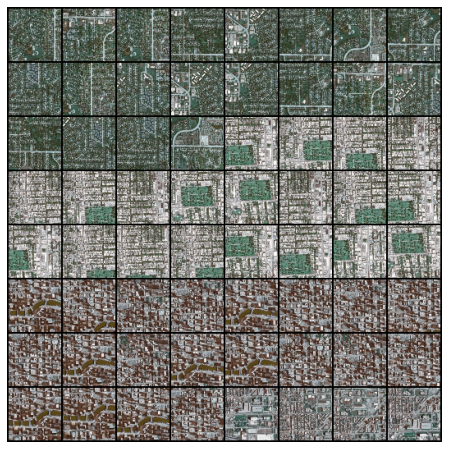

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.imshow(vutils.make_grid(orig_imgs.detach().cpu(), normalize=False).permute(1,2,0))
plt.show()

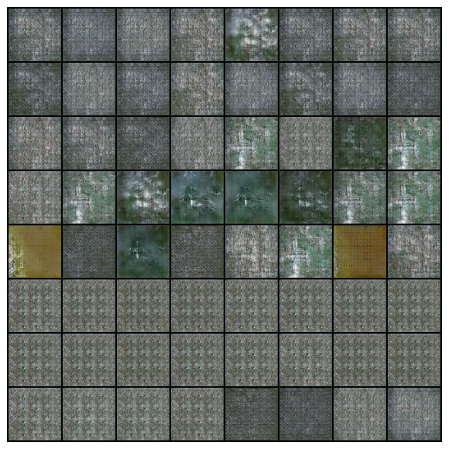

In [50]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.imshow(vutils.make_grid(recon_imgs.detach().cpu(), normalize=False).permute(1,2,0))
plt.show()

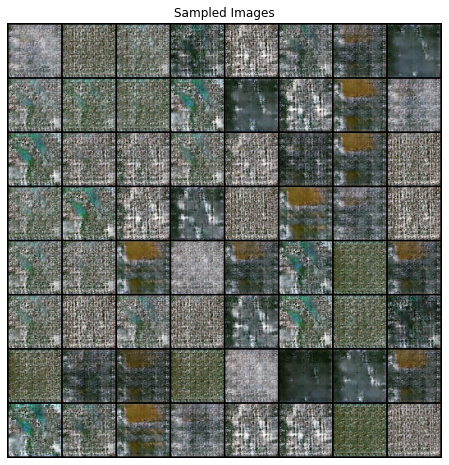

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.set_title("Sampled Images")
ax.imshow(np.transpose(torchvision.utils.make_grid(generated, padding=2, normalize=True).cpu(),(1,2,0)))
# fig.savefig(out_dir+"GAN_"+zoomlevel+"_"+str(model_config['latent_dim'])+"_"+
#     model_run_date+".png", bbox_inches='tight')
